# ROME - example


<br />

for each pair of contiguous convective regions (objects), a, b, in the scene:
<br />

$ROME_{pair} = A_{a} + \text{min}(1, \: \frac{A_{b}}{A_{d}}) \cdot A_b$
<br />
\
Where: \
$A_{a}$ - area of larger object of pair \
$A_{b}$ - area of smaller object of pair \
$A_{d}$ - shortest distance between the two objects, squared

<br />

$ROME = \Biggl\{ 
\begin{matrix}
\frac{1}{k} \cdot \sum_{i=1}^{k} ROME_{pair(i)} & n>1\\
A_{a} & n=1
\end{matrix}$

<br />

Essentially the pairs are the added areas, unless the distance between the objects is larger than the effective square side of the smaller object. \
In that case the contribution from the smaller area to the pair value is modulated (which would be most of the time for our scenes)

In [2]:
import xarray as xr

import numpy as np
import skimage.measure as skm

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeat

import os

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import myPlots
import myFuncs #(if you redefine imported functions you need to restart the kernel)

## convective regions from precipitation fields

### from local

In [3]:
model = 'GFDL-CM3'
experiment = 'historical'
folder = '/Users/cbla0002/Documents/data/cmip5/' + model

In [4]:
fileName = model + '_pr4_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)

In [5]:
ds

<xarray.Dataset>
Dimensions:   (time: 4, lat: 22, lon: 128)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat       (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr4_days  (time, lat, lon) float32 ...

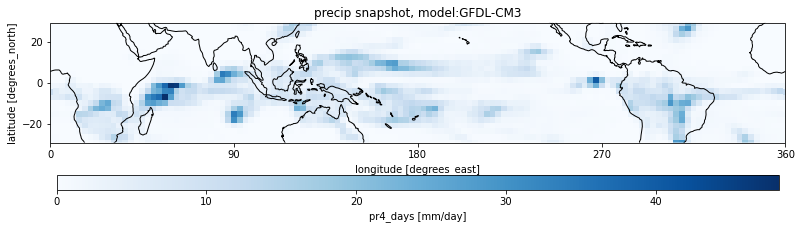

In [6]:
myPlots.plot_snapshot(ds.pr4_days.isel(time=0), 'Blues', 'precip', model)

In [7]:
fileName = model + '_pr_extreme_' + experiment + '.nc'
path = folder + '/' + fileName
ds_percentile = xr.open_dataset(path)

In [8]:
ds_percentile

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr_97    (time) float64 ...
    pr_99    (time) float64 ...
    pr_999   (time) float64 ...

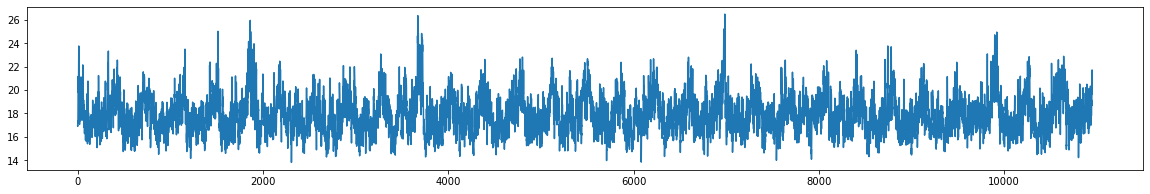

In [9]:
plt.figure(figsize= (20,3))
plt.plot(ds_percentile.pr_97.data)

In [10]:
pr_day = ds.pr4_days.isel(time=0)

In [11]:
# label 8-connected (2-connectivity) objects
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero is necessary to turn true/false to ones and zeros
myFuncs.connect_boundary(L)

In [12]:
L_xr = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': pr_day.lat.data, 'lon': pr_day.lon.data}
    )

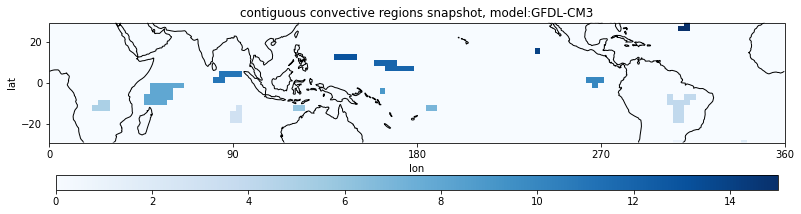

In [13]:
myPlots.plot_snapshot(L_xr, 'Blues', 'contiguous convective regions', model)

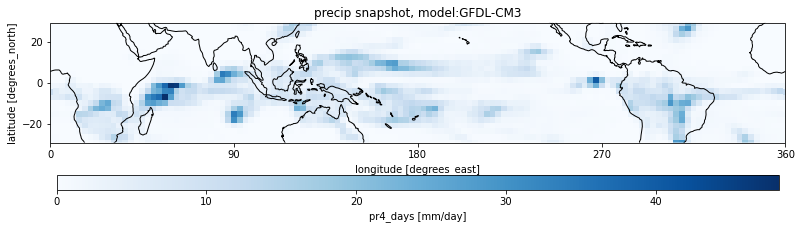

In [14]:
# for comparison
myPlots.plot_snapshot(ds.pr4_days.isel(time=0), 'Blues', 'precip', model)

## ROME

$ROME_{pair} = A_{a} + \text{min}(1, \: \frac{A_{b}}{A_{d}}) \cdot A_b$

In [15]:
# scene to calculate rome from
pr_day = ds.pr4_days.isel(time=0)
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
myFuncs.connect_boundary(L)

labels = np.unique(L)[1:]
print(labels)
print(len(labels))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
15


In [16]:
# see all scenes
for day in np.arange(0,4):
    pr_day = ds.pr4_days.isel(time=day)
    myPlots.plot_snapshot(pr_day, 'Blues', 'precip', model)

In [16]:
# dimensions used for calculation
lat = pr_day.lat.data
lon = pr_day.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

aream3d = np.expand_dims(aream,axis=2) # (usef later for n largest)
latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2)
shape_L = np.shape(L)

In [18]:
# see dimension matrices
f, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (25,3))

p1 = ax1.pcolormesh(lon, lat, latm)
ax1.set_title('latm')
plt.colorbar(p1, ax=ax1, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055,  label = 'latitude') 

p2 = ax2.pcolormesh(lon, lat, lonm)
ax2.set_title('lonm')
plt.colorbar(p2, ax=ax2, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055, label = 'longitude') 

p3 = ax3.pcolormesh(lon, lat, aream)
ax3.set_title('aream')
plt.colorbar(p3, ax=ax3, orientation='horizontal',pad=0.15, aspect=50, fraction=0.055, label = 'area km^2')  

In [17]:
# calculation for one scene
rome_allPairs = []

if len(labels) ==1:
    rome_allPairs = np.sum((L==labels)*1 * aream)

else:
    for idx, labeli in enumerate(labels[0:-1]):
        
        # find coordinates of object i
        I, J = zip(*np.argwhere(L==labeli))
        I = list(I)
        J = list(J)

        # area of object i
        oi_area = np.sum(np.squeeze(aream)[I,J])

        # shortest distance from object i, start by counting the number of gridboxes
        Ni = len(I)

        # replicate each gridbox lon and lat into Ni 2D slices with the shape of L
        lati3d = np.tile(lat[I],reps =[shape_L[0], shape_L[1], 1])
        loni3d = np.tile(lon[J],reps =[shape_L[0], shape_L[1], 1])


        # create corresponding 3D matrix from Ni copies of latm, lonm (this metrix only needs to be recreated when Ni increases from previous loop)
        if Ni > np.shape(lonm3d)[2]:
            lonm3d = np.tile(lonm3d[:,:,0:1],reps =[1, 1, Ni])
            latm3d = np.tile(latm3d[:,:,0:1],reps =[1, 1, Ni])


        # distance from gridboxes of object i to every other point in the domain
        distancei3d = myFuncs.hav_dist(lati3d,loni3d,latm3d[:,:,0:Ni],lonm3d[:,:,0:Ni])

        # minimum in the third dimension gives shortest distance from object i to every other point in the domain
        distancem = np.amin(distancei3d, axis=2)
 
 
        # the shortest distance from object i to object j will be the minimum of the coordinates of object j in distancem
        for labelj in labels[idx+1:]:

            # coordinates of object j
            I, J = zip(*np.argwhere(L==labelj))

            # area of object j
            oj_area = np.sum(aream[I,J])

            # ROME of unique pair
            large_area = np.maximum(oi_area, oj_area)
            small_area = np.maximum(oi_area, oj_area)
            rome_pair = large_area + np.minimum(small_area, (small_area/np.amin(distancem[I,J]))**2)
            rome_allPairs = np.append(rome_allPairs, rome_pair)

In [18]:
len(rome_allPairs)

105

In [19]:
rome_allPairs[0:3]

array([ 172453.98850545,  467557.1875171 , 2218660.24203636])

In [22]:
np.mean(rome_allPairs)

785772.8351974331

In [20]:
# as function
def rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d):
    rome_allPairs = []

    shape_L = np.shape(L)
    if len(labels) ==1:
        rome_allPairs = np.sum((L==labels)*1 * aream)

    else:
        for idx, labeli in enumerate(labels[0:-1]):
            
            # find coordinates of object i
            I, J = zip(*np.argwhere(L==labeli))
            I = list(I)
            J = list(J)

            # area of object i
            oi_area = np.sum(np.squeeze(aream)[I,J])

            # shortest distance from object i, start by counting the number of gridboxes
            Ni = len(I)

            # replicate each gridbox lon and lat into Ni 2D slices with the shape of L
            lati3d = np.tile(lat[I],reps =[shape_L[0], shape_L[1], 1])
            loni3d = np.tile(lon[J],reps =[shape_L[0], shape_L[1], 1])


            # create corresponding 3D matrix from Ni copies of latm, lonm (this metrix only needs to be recreated when Ni increases from previous loop)
            if Ni > np.shape(lonm3d)[2]:
                lonm3d = np.tile(lonm3d[:,:,0:1],reps =[1, 1, Ni])
                latm3d = np.tile(latm3d[:,:,0:1],reps =[1, 1, Ni])


            # distance from gridboxes of object i to every other point in the domain
            distancei3d = myFuncs.hav_dist(lati3d,loni3d,latm3d[:,:,0:Ni],lonm3d[:,:,0:Ni])

            # minimum in the third dimension gives shortest distance from object i to every other point in the domain
            distancem = np.amin(distancei3d, axis=2)
    
    
            # the shortest distance from object i to object j will be the minimum of the coordinates of object j in distancem
            for labelj in labels[idx+1:]:

                # coordinates of object j
                I, J = zip(*np.argwhere(L==labelj))

                # area of object j
                oj_area = np.sum(aream[I,J])

                # ROME of unique pair
                large_area = np.maximum(oi_area, oj_area)
                small_area = np.maximum(oi_area, oj_area)
                rome_pair = large_area + np.minimum(small_area, (small_area/np.amin(distancem[I,J]))**2)
                rome_allPairs = np.append(rome_allPairs, rome_pair)
                
    return np.mean(rome_allPairs)


In [21]:
rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d)

785772.8351974331

$ROME = \Biggl\{ 
\begin{matrix}
\frac{1}{k} \cdot \sum_{i=1}^{k} ROME_{pair(i)} & n>1\\
A_{a} & n=1
\end{matrix}$

In [24]:
# calculation for multiple scenes
rome = []
listOfdays = np.arange(0,4)
array3d_xr = ds.pr4_days

for day in listOfdays:
    pr_day = array3d_xr.isel(time=day)
    L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
    myFuncs.connect_boundary(L)

    labels = np.unique(L)[1:]

    rome = np.append(rome, rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d))
            

In [25]:
len(rome)

4

In [26]:
rome

array([ 785772.83519743, 1007927.57225908, 1121459.70979166,
       1049006.70612288])

In [28]:
# as function
def calc_rome(array3d_xr, conv_threshold, listOfdays, lat, lon, aream, latm3d, lonm3d):
    rome = []

    for day in listOfdays:
        pr_day = array3d_xr.isel(time=day)
        L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
        myFuncs.connect_boundary(L)
        
        labels = np.unique(L)[1:]

        rome = np.append(rome, rome_scene(L, labels, lat, lon, aream, latm3d, lonm3d))
    
    return rome

    # np.mean(rome) for the mean of all days

In [29]:
# calling on data array
array3d_xr = ds.pr4_days
listOfdays = np.arange(0,4)

calc_rome(array3d_xr, conv_threshold, listOfdays, lat, lon, aream, latm3d, lonm3d)


array([ 785772.83519743, 1007927.57225908, 1121459.70979166,
       1049006.70612288])

## ROME n largest

In [30]:
# scene to calculate rome from (same as before)
pr_day = ds.pr4_days.isel(time=0)
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
myFuncs.connect_boundary(L)

labels = np.unique(L)[1:]
print(labels)
print(len(labels))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
15


In [31]:
# dimensions again (same as before)
lat = pr_day.lat.data
lon = pr_day.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

aream3d = np.expand_dims(aream,axis=2) # (usef later for n largest)
latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2)
shape_L = np.shape(L)

In [32]:
# index from labels for n largest objects in L (n=8 in this case)
n = 8
obj3d = np.stack([(L==label) for label in labels],axis=2)*1

o_areaScene = np.sum(obj3d * aream3d, axis=(0,1))

if len(o_areaScene) <= n:
    labels_n = labels
else:
    labels_n = labels[o_areaScene.argsort()[-n:]]


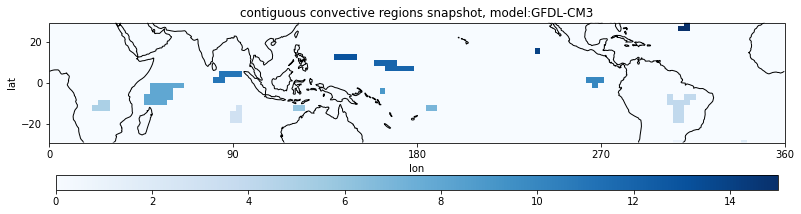

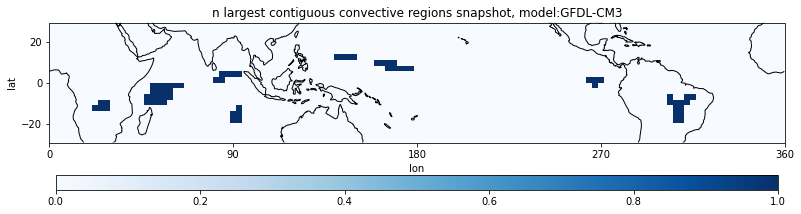

In [31]:
# check plot
L_n = np.sum(np.stack([(L==label) for label in labels_n],axis=2)*1, axis=2)
Ln_xr = xr.DataArray(
    data=L_n,
    dims=['lat', 'lon'],
    coords={'lat': pr_day.lat.data, 'lon': pr_day.lon.data}
    )

myPlots.plot_snapshot(L_xr, 'Blues', 'contiguous convective regions', model)
myPlots.plot_snapshot(Ln_xr, 'Blues', 'n largest contiguous convective regions', model)

In [33]:
# calculating one scene using function from rome_Scene
def rome_nScene(n, o_areaScene, L, labels, lat, lon, aream, latm3d, lonm3d):

    if len(o_areaScene) <= n:
        labels_n = labels
    else:
        labels_n = labels[o_areaScene.argsort()[-n:]]

    return rome_scene(L, labels_n, lat, lon, aream, latm3d, lonm3d)
    

In [34]:
# for multiple scenes
def calc_rome_n(n, array3d_xr, conv_threshold, listOfdays, lat, lon, aream, latm3d, lonm3d): 
    rome_n = []

    for day in listOfdays:
        pr_day = array3d_xr.isel(time=day)
        
        L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
        myFuncs.connect_boundary(L)
        labels = np.unique(L)[1:]

        obj3d = np.stack([(L==label) for label in labels],axis=2)*1 # might not need to define o_areaScene in this function, as it will be calculated for the area distribution index
        o_areaScene = np.sum(obj3d * aream3d, axis=(0,1))

        rome_n = np.append(rome_n, rome_nScene(n, o_areaScene, L, labels, lat, lon, aream, latm3d, lonm3d))
    
    return rome_n

In [35]:
# calling on data array
array3d_xr = ds.pr4_days
listOfdays = np.arange(0,4)

calc_rome_n(n, array3d_xr, conv_threshold, listOfdays, lat, lon, aream, latm3d, lonm3d)

array([1161780.14146767, 1346991.16169837, 1419596.73170682,
       1421017.18416433])

## testing on artificial fields

In [36]:
artScenes = xr.zeros_like(ds.pr4_days) # shape = (4, 22, 128)

In [37]:
artScenes

<xarray.DataArray 'pr4_days' (time: 4, lat: 22, lon: 128)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    mm/day

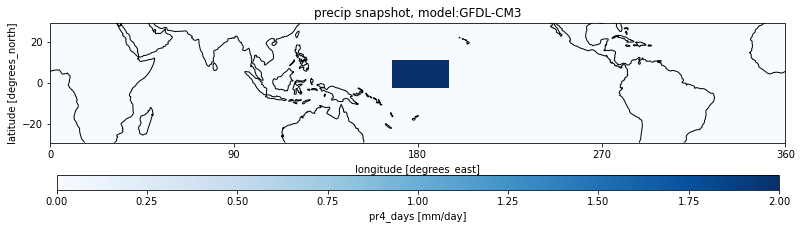

In [38]:
# only one object
artScenes[0, :, :] = 0
artScenes[0, 10:15, 60:70] = 2

myPlots.plot_snapshot(artScenes.isel(time=0), 'Blues', 'precip', model)

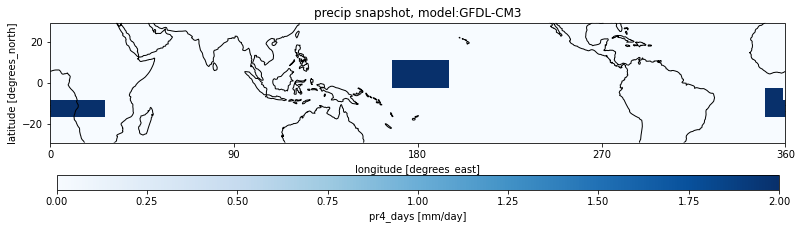

In [39]:
# two objects (across boundary)
artScenes[1, :, :] = 0
artScenes[1, 10:15, 60:70] = 2

artScenes[1, 5:8, 0:10] = 2
artScenes[1, 5:10, 125:] = 2

myPlots.plot_snapshot(artScenes.isel(time=1), 'Blues', 'precip', model)

In [46]:
# testing that connect_boundary function recognizes that there are only two objects
pr_day = artScenes.isel(time=1)
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2) # the greater than zero turns ones and zeros to True/False
myFuncs.connect_boundary(L)
labels = np.unique(L)[1:]
print('labels:', labels)

labels: [1 3]


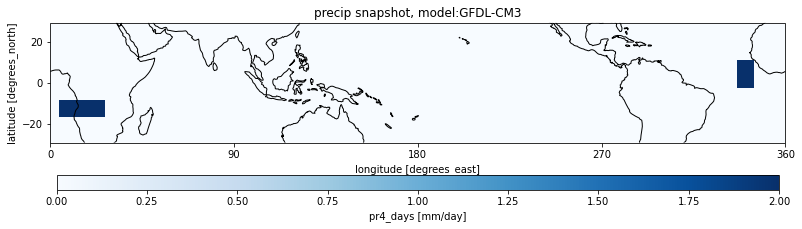

In [40]:
# two objects (across boundary is closer)
artScenes[2, :, :] = 0
artScenes[2, 5:8, 2:10] = 2

artScenes[2, 10:15, 120:-5] = 2

myPlots.plot_snapshot(artScenes.isel(time=2), 'Blues', 'precip', model)

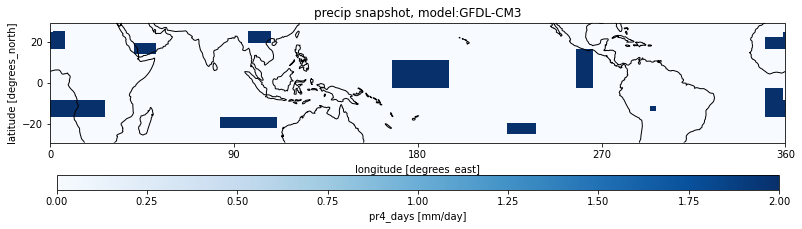

In [41]:
# multiple objects (including crossing boundary multiple times) (9 objects)
artScenes[3, :, :] = 0
artScenes[3, 10:15, 60:70] = 2

artScenes[3, 5:8, 0:10] = 2
artScenes[3, 5:10, 125:] = 2

artScenes[3, 17:20, 0:3] = 2
artScenes[3, 17:19, 125:] = 2

artScenes[3, 16:18, 15:19] = 2

artScenes[3, 3:5, 30:40] = 2

artScenes[3, 10:17, 92:95] = 2

artScenes[3, 6:7, 105:106] = 2

artScenes[3, 2:4, 80:85] = 2

artScenes[3, 18:20, 35:39] = 2

myPlots.plot_snapshot(artScenes.isel(time=3), 'Blues', 'precip', model)

In [42]:
# dimensions used for calculation
lat = artScenes.lat.data
lon = artScenes.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)
aream3d = np.expand_dims(aream,axis=2) # (usef later for n largest)

latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2)
shape_L = np.shape(L)

In [43]:
conv_threshold = 1
listOfdays = np.arange(0,4)
array3d_xr = artScenes

calc_rome(array3d_xr, conv_threshold, listOfdays, lat, lon, aream, latm3d, lonm3d)

array([4827671.79015079, 4923618.49067871, 3002871.37739624,
       3086426.3790066 ])

In [44]:
calc_rome_n(n, array3d_xr, conv_threshold, listOfdays, lat, lon, aream, latm3d, lonm3d)

array([4827671.79015079, 4923618.49067871, 3002871.37739624,
       3335035.94672444])